In [1]:
import numpy as np
import pandas as pd
from scipy.stats import circmean
from scipy.fftpack import fft, rfft, irfft, fftfreq
from scipy.signal import freqz, lfilter, iirnotch, iirpeak, welch, csd, hilbert
from matplotlib import pyplot as plt

## Task 1: Filters and cleaning noise

### Section A

1

2

3

4

### Section B

In [2]:
var4students = np.load("data/var4students.npy", allow_pickle=True)
blank = var4students.item().get("blank")
stimulus = var4students.item().get("stimulus")

In [3]:
Fs = 100
T, N = blank.shape

time = 1000 * np.arange(T) / Fs

In [4]:
def find_stats(arr, keepdims=False):

    arr_mean = np.mean(arr, axis=1, keepdims=keepdims)
    arr_sem = np.std(arr, axis=1) / np.sqrt(arr.shape[1] - 1)

    return arr_mean, arr_sem

def plot_stats(time, arr_mean, arr_sem, label=""):

    plt.plot(time, arr_mean, label=label)
    plt.fill_between(time, arr_mean - arr_sem, arr_mean + arr_sem, alpha=0.5)

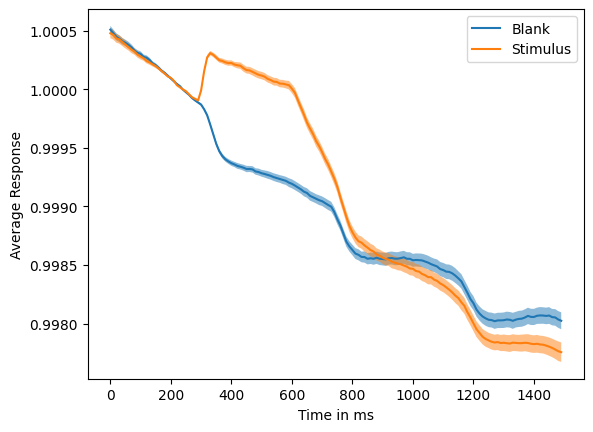

In [5]:
blank_mean, blank_sem = find_stats(blank)
stimulus_mean, stimulus_sem = find_stats(stimulus)

plot_stats(time, blank_mean, blank_sem, label="Blank")
plot_stats(time, stimulus_mean, stimulus_sem, label="Stimulus")

plt.xlabel("Time in ms") 
plt.ylabel("Average Response")
plt.legend(loc="upper right")

The frequencies bla bla are clearly shown 2.5 Hz

### Section C

In [6]:
freq = fftfreq(T, d=1 / Fs)

blank_power = np.apply_along_axis(fft, 0, blank - np.mean(blank))
stimulus_power = np.apply_along_axis(fft, 0, stimulus - np.mean(stimulus))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:5472: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:5473: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:5476: ComplexWarning: Casting complex values to real discards the i

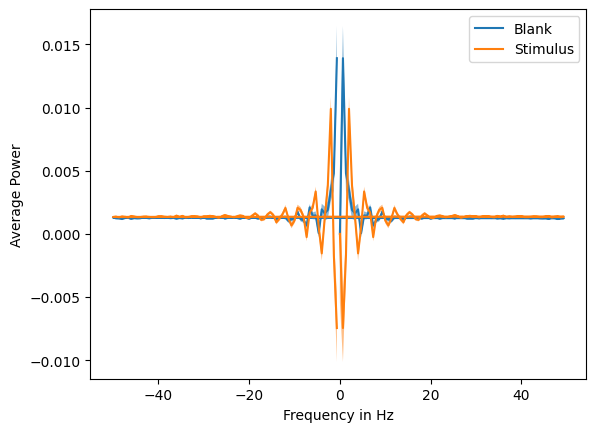

In [7]:
blank_power_mean, blank_power_sem = find_stats(blank_power)
stimulus_power_mean, stimulus_power_sem = find_stats(stimulus_power)

plot_stats(freq, blank_power_mean, blank_power_sem, label="Blank")
plot_stats(freq, stimulus_power_mean, stimulus_power_sem, label="Stimulus")

plt.xlabel("Frequency in Hz") 
plt.ylabel("Average Power")
plt.legend(loc="upper right")

In [60]:
f0 = 2.5
bandwidth = 0.1

b, a = iirnotch(f0, f0 / bandwidth, Fs)

impulse = np.zeros(T)
impulse[0] = 1

impulse_response = lfilter(b, a, impulse)

# Compute the frequency response
freq_range, freq_response = freqz(b, a, fs=Fs)

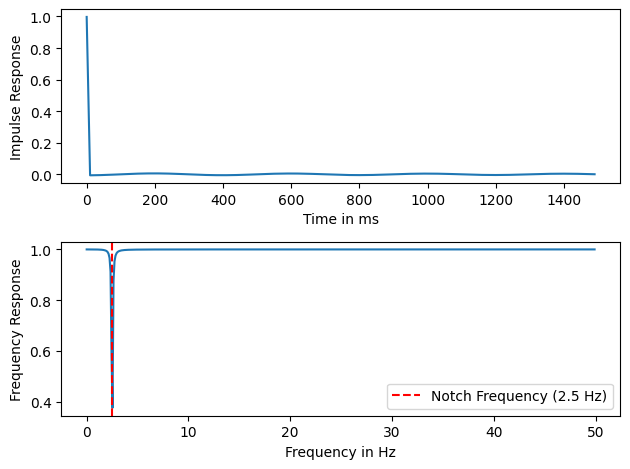

In [61]:
fig, axes = plt.subplots(2)

# Plot the impulse response
axes[0].plot(time, impulse_response)

axes[0].set_xlabel("Time in ms")
axes[0].set_ylabel("Impulse Response")

# Plot the frequency response
axes[1].plot(freq_range, freq_response)
axes[1].axvline(f0, color="r", linestyle="--", label=f"Notch Frequency ({f0} Hz)")

axes[1].set_xlabel("Frequency in Hz")
axes[1].set_ylabel("Frequency Response")
axes[1].legend()

plt.tight_layout()

IIR notch filter to remove single frequencies with bandwidth 0.1

In [62]:
def apply_filter(sig, freq, power, Fs, freq_range=[2, 5], bandwidth=0.1):
    
    range_idx = np.where((freq >= freq_range[0]) & (freq <= freq_range[1]), True, False)
    max_idx = np.argmax(power[range_idx, :], axis=0)
    
    heartbeat = freq[range_idx][max_idx]
    filtered_sig = np.zeros_like(sig)
    
    for i in range(heartbeat.size):
        
        b, a = iirnotch(heartbeat[i], heartbeat[i] / bandwidth, Fs)
        filtered_trial = lfilter(b, a, sig[:, i])
        filtered_sig[:, i] = filtered_trial

    return filtered_sig

In [63]:
filtered_blank = apply_filter(blank, freq, blank_power, Fs)
filtered_stimulus = apply_filter(stimulus, freq, stimulus_power, Fs)

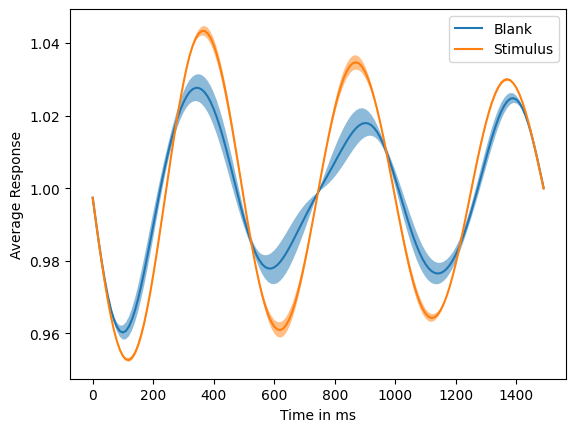

In [64]:
filtered_blank_mean, filtered_blank_sem = find_stats(filtered_blank)
filtered_stimulus_mean, filtered_stimulus_sem = find_stats(filtered_stimulus)

plot_stats(time, filtered_blank_mean, filtered_blank_sem, label="Blank")
plot_stats(time, filtered_stimulus_mean, filtered_stimulus_sem, label="Stimulus")

plt.xlabel("Time in ms") 
plt.ylabel("Average Response")
plt.legend(loc="upper right")

### Section D

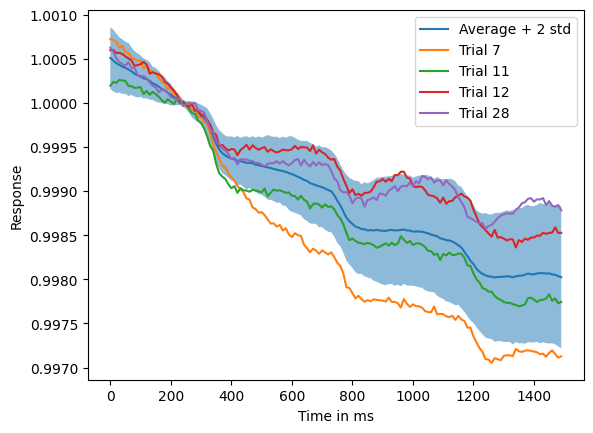

In [65]:
blank_std = np.std(blank, axis=1)
outliers = [7, 11, 12, 28]

plot_stats(time, blank_mean, 2 * blank_std, label='Average + 2 std')

for i in outliers:
    plt.plot(time, blank[:, i], label=f"Trial {i}")

plt.xlabel("Time in ms")
plt.ylabel("Response")
plt.legend()

In [66]:
tidy_blank = np.delete(blank, outliers, axis=1)

tidy_blank_mean, tidy_blank_sem = find_stats(tidy_blank, keepdims=True)

norm_stimulus = stimulus / tidy_blank_mean

norm_stimulus_mean, norm_stimulus_sem = find_stats(norm_stimulus)

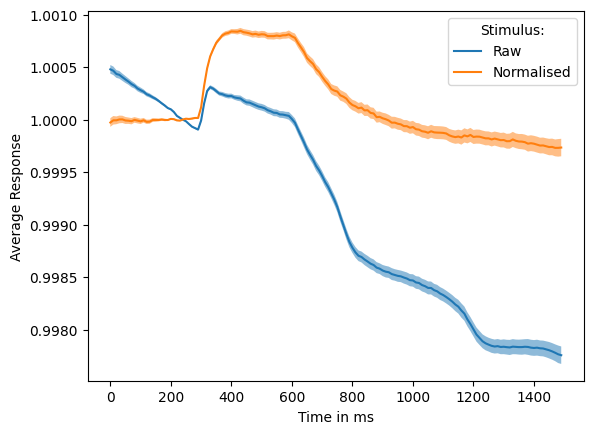

In [67]:
plot_stats(time, stimulus_mean, stimulus_sem, label="Raw")
plot_stats(time, norm_stimulus_mean, norm_stimulus_sem, label="Normalised")

plt.xlabel("Time in ms")
plt.ylabel("Average Response")
plt.legend(title="Stimulus:", loc="upper right")

### Section E

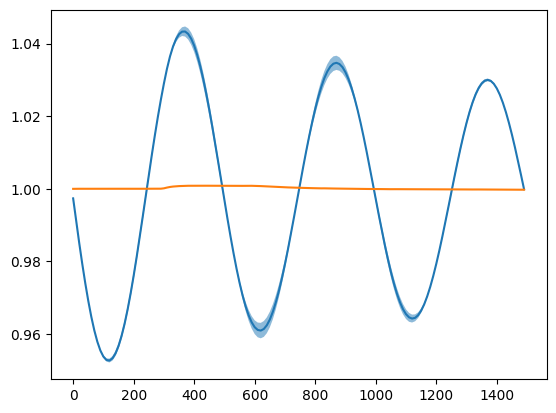

In [68]:
plot_stats(time, filtered_stimulus_mean, filtered_stimulus_sem, label="Filtered")
plot_stats(time, norm_stimulus_mean, norm_stimulus_sem, label="Normalised")

(0.0, 2.0)

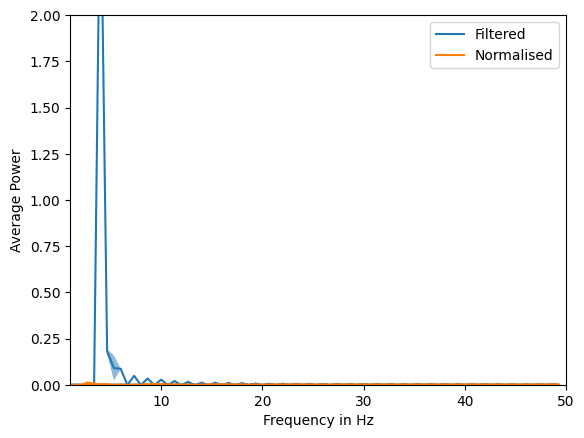

In [69]:
filtered_stimulus_power = np.apply_along_axis(rfft, 0, filtered_stimulus)
norm_stimulus_power = np.apply_along_axis(rfft, 0, norm_stimulus)

filtered_stimulus_power_mean, filtered_stimulus_power_sem = find_stats(filtered_stimulus_power)
norm_stimulus_power_mean, norm_stimulus_power_sem = find_stats(norm_stimulus_power)

plot_stats(freq, filtered_stimulus_power_mean, filtered_stimulus_power_sem, label="Filtered")
plot_stats(freq, norm_stimulus_power_mean, norm_stimulus_power_sem, label="Normalised")

plt.xlabel("Frequency in Hz") 
plt.ylabel("Average Power")
plt.legend(loc="upper right")

plt.xlim([1, 50])
plt.ylim([0, 2])

## Task 2: Fourier Transform

### Section A

A signal $x(t)$ is given for which the Fourier transform $X(\omega)$ must be calculated:

$x(t) = cos(2\pi \alpha t)\cdot cos(2\pi \beta t)$

The trigonometric property of multiplication holds such that:

$cos\alpha\cdot cos\beta = \frac{1}{2}[cos(\alpha - \beta) + cos(\alpha + \beta)]$

It can be applied to $x(t)$ so that:

$x(t) = \frac{1}{2}[cos2\pi (\alpha - \beta)t + cos2\pi (\alpha + \beta)t]$

The Fourier transform $X(\omega)$ of a signal $x(t)$ is defined as:

$X(\omega) = \int_{-\infty}^{+\infty}x(t)\cdot e^{-i\omega t}dt$

In which formula we replace $x(t)$ with its extended expression and separate the integrals of the two addends:

$X(\omega) = \frac{1}{2}\int_{-\infty}^{+\infty}cos2\pi (\alpha - \beta)t\cdot e^{-i\omega t}dt + \frac{1}{2}\int_{-\infty}^{+\infty}cos2\pi (\alpha + \beta)t\cdot e^{-i\omega t}dt$

Because each of the two integrals contain two functions (a cosine and an exponential), they can be solved with integration by parts:

$\int_{a}^{b}u\cdot v' = u\cdot v - \int_{a}^{b}u'\cdot v$

Moreover, the two integrals only differ in the frequency term, which can be substituted with a placeholder:

$k = \alpha - \beta$ and $j = \alpha + \beta$

We start by solving the first integral $\frac{1}{2}\int_{-\infty}^{+\infty}cos2\pi kt\cdot e^{-i\omega t}dt$ by parts:

$\frac{1}{2}\int_{-\infty}^{+\infty}cos2\pi kt\cdot e^{-i\omega t}dt = -\frac{1}{2i\omega}[cos2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty} + \frac{\pi k}{i\omega}\int_{-\infty}^{+\infty}sin2\pi kt\cdot e^{-i\omega t}dt$

Integration by parts is applied again to the integral which appeared in the right side of the equation:

$\int_{-\infty}^{+\infty}sin2\pi kt\cdot e^{-i\omega t}dt = -\frac{1}{i\omega}[sin2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty} + 2\frac{\pi k}{i\omega}\int_{-\infty}^{+\infty}cos2\pi kt\cdot e^{-i\omega t}dt$

When the solution of $\int_{-\infty}^{+\infty}sin2\pi kt\cdot e^{-i\omega t}dt$ is plugged in the original equation, we are left with two identical integrals in both sides of the equation:

$\frac{1}{2}\int_{-\infty}^{+\infty}cos2\pi kt\cdot e^{-i\omega t}dt = -\frac{1}{2i\omega}[cos2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty} - \frac{\pi k}{i^2\omega^2}[sin2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty} + 2\frac{\pi^2 k^2}{i^2\omega^2}\int_{-\infty}^{+\infty}cos2\pi kt\cdot e^{-i\omega t}dt$

The following properties of imaginary numbers are given:

$i^2 = \sqrt{-1^2} = -1$ and $i^{-1} = i \cdot i^{-2} = -i$

They can be applied to the members in the right side of the equation to simplify the signs:

$\frac{1}{2}\int_{-\infty}^{+\infty}cos2\pi kt\cdot e^{-i\omega t}dt = \frac{i}{2\omega}[cos2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty} + \frac{\pi k}{\omega^2}[sin2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty} - 2\frac{\pi^2 k^2}{\omega^2}\int_{-\infty}^{+\infty}cos2\pi kt\cdot e^{-i\omega t}dt$

Next, the integral in the right side is moved to the left side and the two identical integrals are summed:

$\frac{4\pi^2 k^2 + \omega^2}{2\omega^2}\int_{-\infty}^{+\infty}cos2\pi kt\cdot e^{-i\omega t}dt = \frac{i}{2\omega}[cos2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty} + \frac{\pi k}{\omega^2}[sin2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty}$

The coefficient of the integral is then moved to the right side by multiplication with its inverse:

$\frac{1}{2}\int_{-\infty}^{+\infty}cos2\pi kt\cdot e^{-i\omega t}dt = \frac{i\omega}{2(4\pi^2 k^2 + \omega^2)}[cos2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty} + \frac{\pi k}{4\pi^2 k^2 + \omega^2}[sin2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty}$

To obtain the answer for the second addend $\frac{1}{2}\int_{-\infty}^{+\infty}cos2\pi jt\cdot e^{-i\omega t}dt$, all occurrences of $k$ can be simply replaced with $j$. The expressions of the two integrals by parts can be plugged in the definition of $X(\omega)$:

$X(\omega) = \frac{\pi k}{4\pi^2 k^2 + \omega^2}[sin2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty} + \frac{\pi j}{4\pi^2 j^2 + \omega^2}[sin2\pi jt\cdot e^{-i\omega t}]_{-\infty}^{+\infty} + \frac{i\omega}{2(4\pi^2 k^2 + \omega^2)}[cos2\pi kt\cdot e^{-i\omega t}]_{-\infty}^{+\infty} + \frac{i\omega}{2(4\pi^2 j^2 + \omega^2)}[cos2\pi jt\cdot e^{-i\omega t}]_{-\infty}^{+\infty}$

We observe that the first two elements represent the real part and the second two elements the imaginary part of the Fourier transform.

### Section B

The two parameters $\alpha$ and $\beta$ are now given:

$\alpha = 10$ and $\beta = 110$

The two parameters can be plugged in the equation of $x(t)$:

$x(t) = cos(2\pi 10 t)\cdot cos(2\pi 110 t)$

The trigonometric property of multiplication is applied as before:

$x(t) = \frac{1}{2}[cos2\pi (-100)t + cos2\pi (120)t]$

The cosine function is characterised by the property of symmetry such that:

$cos(-x) = cos(x)$

Thus, the negative angle can be replaced with its positive counterpart:

$x(t) = \frac{1}{2}[cos2\pi (100)t + cos2\pi (120)t]$

The Nyquist frequency of a signal is defined as its maximal frequency:

$f_{max} = \frac{f_s}{2} = 120 s^{-1}$

To prevent aliasing, the sampling rate must be at least twice as great as the Nyquist frequency:

$\Rightarrow f_s \ge 2f_{max} = 240 s^{-1}$

In conclusion, the signal must be sampled at a frequency of at least 240 Hz to prevent aliasing.

### Section C

In [70]:
# Set sampling rates
Fs1, Fs2 = 160, 250
# Set experiment length
T = 2

# Collect sample times
t1 = np.linspace(0, T, T * Fs1)
t2 = np.linspace(0, T, T * Fs2)

In [71]:
# Set signal parameters
a, b = 10, 110

y1 = np.cos(2 * np.pi * a * t1) * np.cos(2 * np.pi * b * t1)
y2 = np.cos(2 * np.pi * a * t2) * np.cos(2 * np.pi * b * t2)

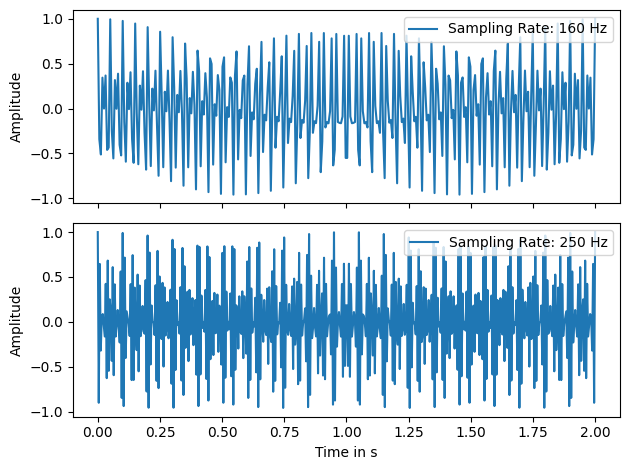

In [72]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise signal at first sampling rate
axes[0].plot(t1, y1, label=f"Sampling Rate: {Fs1} Hz")
# Visualise signal at second sampling rate
axes[1].plot(t2, y2, label=f"Sampling Rate: {Fs2} Hz")

axes[0].set_ylabel("Amplitude")
axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("Time in s")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

In [77]:
# Collect frequencies at first sampling rate
freq1 = fftfreq(T * Fs1, d=1 / Fs1)
# Collect frequencies at second sampling rate
freq2 = fftfreq(T * Fs2, d=1 / Fs2)

# Perform FFT
Y1 = fft(y1)
Y2 = fft(y2)

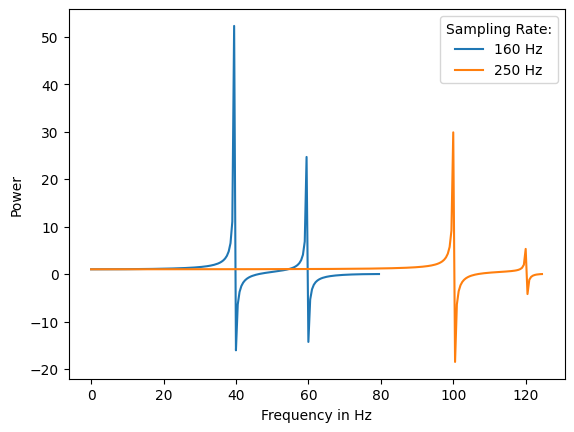

In [89]:
# Visualise positive spectrum for the two sampling rates
plt.plot(freq1[:T * Fs1 // 2], Y1[:T * Fs1 // 2], label=f"{Fs1} Hz")
plt.plot(freq2[:T * Fs2 // 2], Y2[:T * Fs2 // 2], label=f"{Fs2} Hz")

plt.xlabel("Frequency in Hz")
plt.ylabel("Power")
plt.legend(title="Sampling Rate:")

## Task 3: Filters

### Section A

In [262]:
filters = np.load("data/filters.npy", allow_pickle=True)
filtVec = filters.item().get("filtVec")
dataVec = filters.item().get("dataVec").flatten()

In [263]:
def apply_filter(x, f):
    
    y = np.zeros((f.shape[0], x.size))

    for n in range(x.size):
        for k in range(filtVec.shape[1]):
            y[:, n] += f[:, k] * x[n - k]

    return y

In [264]:
impulse = np.zeros(filtVec.shape[1])
impulse[0] = 1

response = apply_filter(impulse, filtVec)

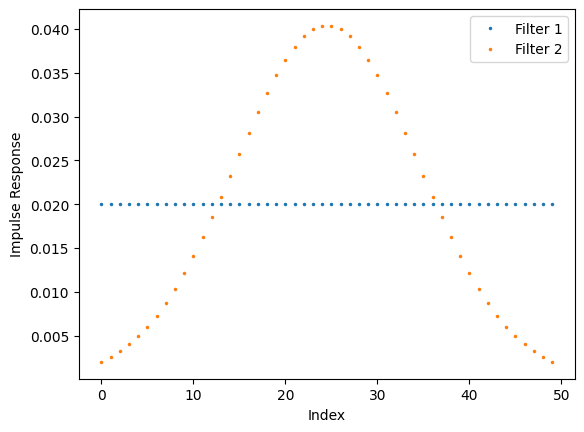

In [265]:
plt.plot(response.T, ".", markersize=3)

plt.xlabel("Index")
plt.ylabel("Impulse Response")
plt.legend(["Filter 1", "Filter 2"])

### Section B

In [266]:
y = apply_filter(dataVec, filtVec)

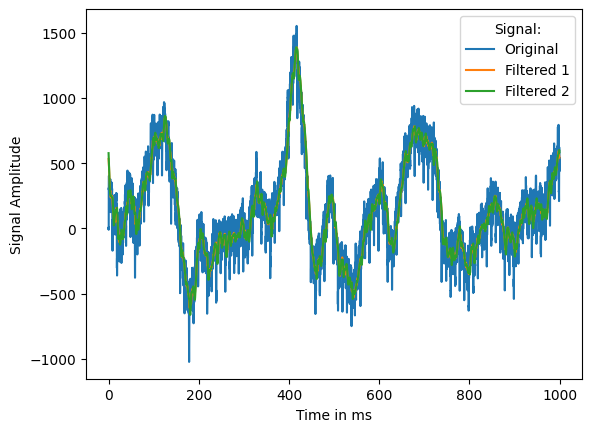

In [267]:
time = np.arange(dataVec.size) / 10
plt.plot(time, dataVec, linewidth=1.5)
plt.plot(time, y.T, linewidth=1.5)

plt.xlabel("Time in ms")
plt.ylabel("Signal Amplitude")
plt.legend(["Original", "Filtered 1", "Filtered 2"], title="Signal:")

### Section C

In [272]:
Fs = dataVec.size
T = 1

x = np.linspace(0, Fs * T, Fs)
xf = np.linspace(0, 1 / (2 * T), Fs // 2)

y0 = 2 / Fs * np.abs(fft(dataVec))[:Fs // 2]
yf = 2 / Fs * np.abs(fft(y))[:, :Fs // 2]

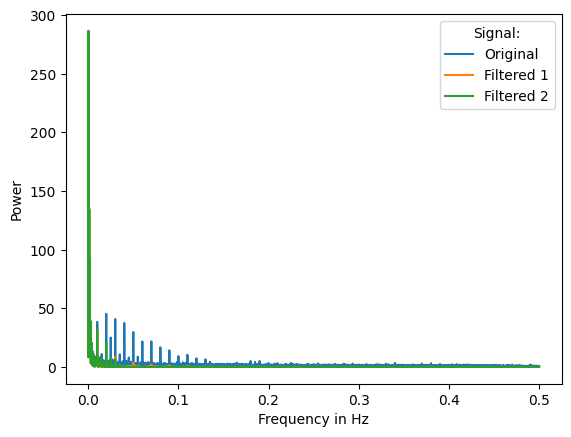

In [269]:
plt.plot(xf, y0)
plt.plot(xf, yf.T)

plt.xlabel("Frequency in Hz")
plt.ylabel("Power")
plt.legend(["Original", "Filtered 1", "Filtered 2"], title="Signal:")

Plotted only positive frequencies, resolution or frequency step is 1 / (2 * T) Hz, whereas max is Nyquist frequency Fs / 2 Hz.

### Section D

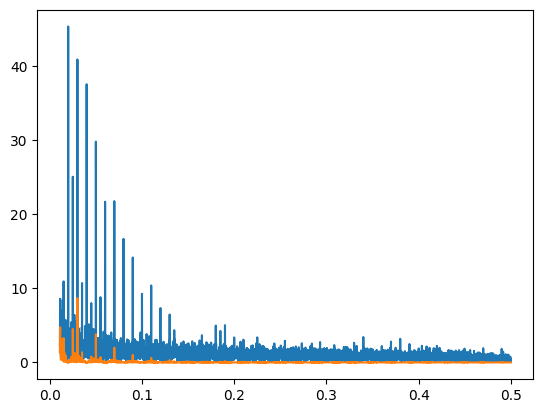

In [271]:
plt.plot(xf[110:], y0[110:])
plt.plot(xf[110:], yf[0, 110:].T)

Filter 1 is lowpass FIR with sharp descent and a lot of wripples. Filter 2 is lowpass FIR with gradual descent and few wripples.

### Section E

In [43]:
# cool that impulse response sums up to 1
np.sum(response, axis=1)

array([1., 1.])

Compared to ideal filter, filter 1 has lots of wripples due to sharp descent, whereas filter 2 does not have wripples but is not able to preserve original frequencies within the band because of very gradual ascent and descent.

## Task 4: PSD and Coherence

### Section A and B

In [42]:
coherence = np.load("data/coherence.npy", allow_pickle=True)
fwrsig_nospikes = coherence.item().get("fwrsig_nospikes").flatten()
st = coherence.item().get("st").toarray().flatten()

In [43]:
Fs = 24038

freq, fwr_power = welch(fwrsig_nospikes, Fs, noverlap=0, nperseg=2 * Fs)
freq, st_power = welch(st, Fs, noverlap=0, nperseg=2 * Fs)

fwr_power = fwr_power.flatten()
st_power = st_power.flatten()

In [44]:
min_plot_freq, min_norm_freq, max_freq = 3, 30, 70
norm_idx = np.where((freq >= min_norm_freq) & (freq <= max_freq))
plot_idx = np.where((freq >= min_plot_freq) & (freq <= max_freq))

norm_fwr_power = fwr_power[plot_idx] / np.sum(fwr_power[norm_idx])
norm_st_power = st_power[plot_idx] / np.sum(st_power[norm_idx])

In [45]:
fwr_mean = np.mean(norm_fwr_power)
fwr_std = np.std(norm_fwr_power)

st_mean = np.mean(norm_st_power)
st_std = np.std(norm_st_power)

fwr_threshold = fwr_mean + 5 * fwr_std
st_threshold = st_mean + 5 * st_std

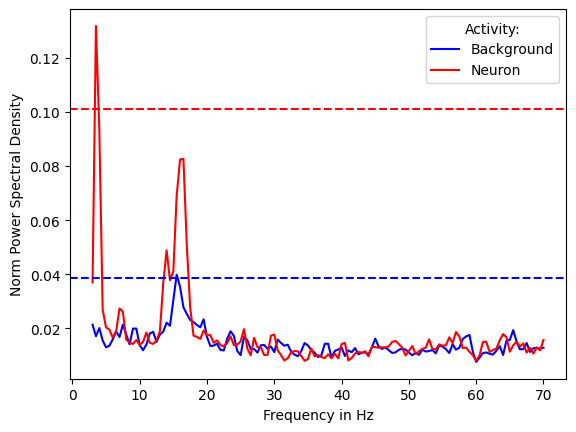

In [46]:
plt.plot(freq[plot_idx], norm_fwr_power, label="Background", c="b")
plt.plot(freq[plot_idx], norm_st_power, label="Neuron", c="r")

plt.axhline(y=fwr_threshold, linestyle="--", c="b")
plt.axhline(y=st_threshold, linestyle="--", c="r")

plt.xlabel("Frequency in Hz")
plt.ylabel("Norm Power Spectral Density")
plt.legend(title="Activity:")

In [47]:
fwr_keep = freq[plot_idx][norm_fwr_power > fwr_threshold]
st_keep = freq[plot_idx][norm_st_power > st_threshold]

print("Principal Oscillation Frequency:")
print(f"fwr: {fwr_keep[0]} Hz")
print(f"st: {st_keep[0]} Hz")

Principal Oscillation Frequency:
fwr: 15.5 Hz
st: 3.5 Hz


### Section C

In [48]:
freq, cross_spectrum = csd(fwrsig_nospikes, st, Fs, noverlap=0, nperseg=2 * Fs)
cross_spectrum = cross_spectrum[plot_idx]

Text(0, 0.5, 'Cross Spectral Density')

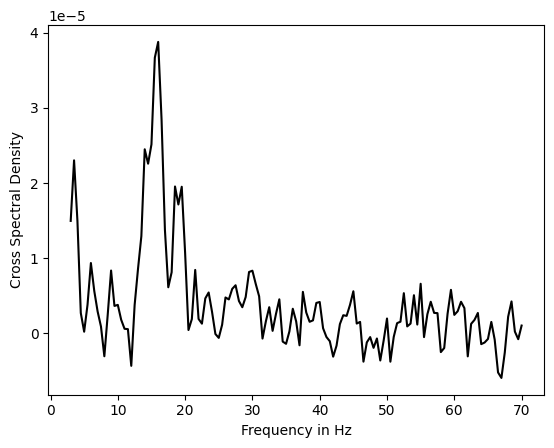

In [49]:
plt.plot(freq[plot_idx], cross_spectrum, label="Background", c="k")

plt.xlabel("Frequency in Hz")
plt.ylabel("Cross Spectral Density")

### Section D

In [50]:
coherence = np.abs(cross_spectrum)**2 / (fwr_power[plot_idx] * st_power[plot_idx])

Text(0, 0.5, 'Coherence')

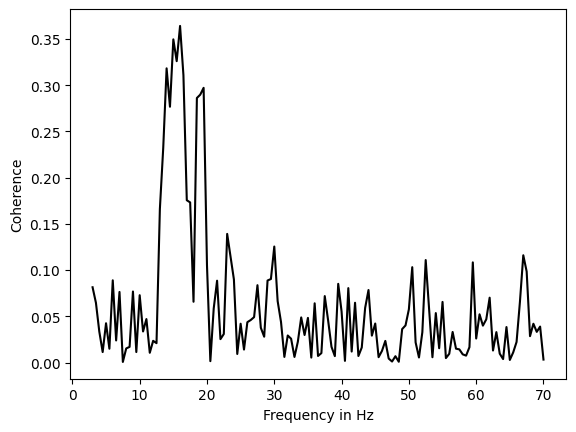

In [51]:
plt.plot(freq[plot_idx], coherence, c="k")

plt.xlabel("Frequency in Hz")
plt.ylabel("Coherence")

### Section E

In [52]:
# Set bandwidth as half frequency resolution
bandwidth = 0.25

# Design IIR peak filter for 
b, a = iirpeak(fwr_keep, fwr_keep / bandwidth, Fs)
filtered_fwr = lfilter(b, a, fwrsig_nospikes)

# Design IIR peak filter for stimulus activity
b, a = iirpeak(st_keep, st_keep / bandwidth, Fs)
# Apply filter to stimulus activity
filtered_st = lfilter(b, a, st)

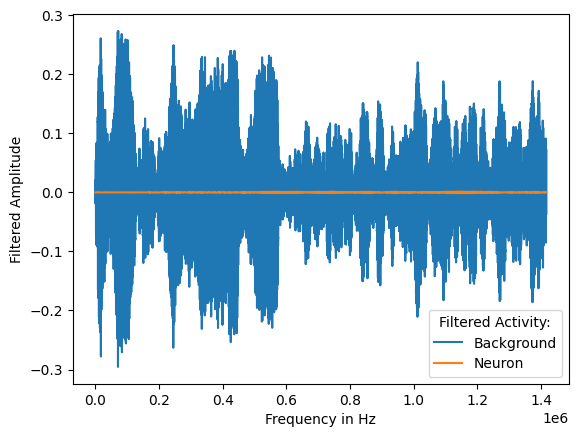

In [53]:
plt.plot(filtered_fwr, label="Background")
plt.plot(filtered_st, label="Neuron")

plt.xlabel("Frequency in Hz")
plt.ylabel("Filtered Amplitude")
plt.legend(title="Filtered Activity:")

In [54]:
analytic_fwr = hilbert(filtered_fwr)
spike_background = analytic_fwr[st == 1]

amplitude_envelope = np.abs(spike_background)
phase = np.angle(spike_background)

phase_mean = np.rad2deg(circmean(phase, low=phase.min(), high=phase.max()))

print(f"Most exciting phase computed by circular mean: {phase_mean:.3g}°")

Most exciting phase computed by circular mean: -92.1°


Text(0.5, 1.0, 'Phase of Background Activity upon Spike')

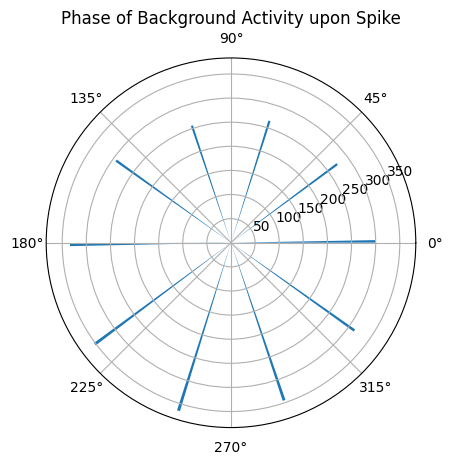

In [55]:
ax = plt.subplot(polar=True)

ax.hist(phase, width=np.deg2rad(1))

ax.set_title("Phase of Background Activity upon Spike")

### Section F

Describe differences, pluses and cons of coherence and phase locking.